# Benchmark #2:

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using HDF5
using CSV

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using PyPlot

In [4]:
# using Revise
using BAT

## Functions: 

In [5]:
function convert_to_typed_table(table)
    density_integral = [Measurements.measurement(parse.(Float64, split(v_run, " ± "))...) for v_run in table.density_integral]
    integration_cpu_time = collect(table.integration_cpu_time)
    sampling_cpu_time = collect(table.sampling_cpu_time)
    n_threads = collect(table.n_threads)
    worker_id = collect(table.worker_id)
    sum_weights = collect(table.sum_weights)
    samples_ind = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.samples_ind ]
    sampling_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.sampling_wc ]
    integration_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.integration_wc ]
    
    TypedTables.Table(
        density_integral=density_integral,
        integration_cpu_time=integration_cpu_time,
        sampling_cpu_time=sampling_cpu_time,
        n_threads=n_threads,
        worker_id=worker_id,
        sum_weights=sum_weights,
        samples_ind=samples_ind,
        sampling_wc=sampling_wc,
        integration_wc=integration_wc
    )
end

convert_to_typed_table (generic function with 1 method)

In [6]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

function get_sampling_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.sampling_cpu_time)
end

function get_integration_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.integration_cpu_time)
end

function get_sampling_wc_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.sampling_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_integration_wc_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.integration_wc]))* 10^-9
end

function get_integrals(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return exp(log(sum(table.density_integral)) + 47.684856298932324)
end

function get_nsamples(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return table.samples_ind[end][end]
end

function get_nthreads(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return table.n_threads[1]
end

get_nthreads (generic function with 1 method)

## Parse Data: 

In [7]:
names = ["1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10."]

path = "../data/Benchmark-2/1/table"
path2 = "../data/Benchmark-2/1/samples"

tbl = "csv"
smpl = "hdf5"

"hdf5"

In [8]:
run_data = Table(
    ind = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    length_samples = [get_nsamples(t) for t in path.*names.*tbl],
    cpu_sampling_time = [get_sampling_cpu_time(t) for t in path .* names.*tbl],
    cpu_integration_time = [get_integration_cpu_time(t) for t in path .* names.*tbl],
    wc_sampling_time = [get_sampling_wc_time(t) for t in path .* names.*tbl],
    wc_integration_time = [get_integration_wc_time(t) for t in path .* names.*tbl],
    n_chains=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
    n_threads = [get_nthreads(t) for t in path .* names.*tbl]
)

Table with 8 columns and 10 rows:
      ind  length_samples  cpu_sampling_time  cpu_integration_time  ⋯
    ┌────────────────────────────────────────────────────────────────
 1  │ 1    1000000         219.418            101.01                ⋯
 2  │ 2    1000000         305.407            100.682               ⋯
 3  │ 3    1000000         338.553            89.9315               ⋯
 4  │ 4    1000000         422.455            104.035               ⋯
 5  │ 5    1000000         506.163            107.989               ⋯
 6  │ 6    1000000         589.823            107.869               ⋯
 7  │ 7    1000000         610.284            111.784               ⋯
 8  │ 8    1000000         622.313            111.425               ⋯
 9  │ 9    1000000         685.572            117.869               ⋯
 10 │ 10   1000000         853.224            119.758               ⋯

## Run overview:

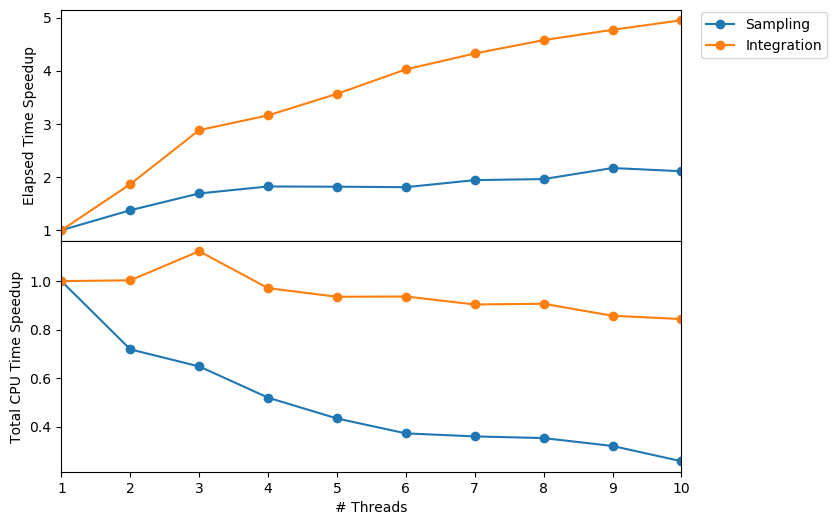

(1, 10)

In [9]:
sampling_wc_time = run_data.wc_sampling_time[1]
integration_wc_time = run_data.wc_integration_time[1]

sampling_cpu_time = run_data.cpu_sampling_time[1]
integration_cpu_time = run_data.cpu_integration_time[1]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_data.n_threads,  sampling_wc_time ./ run_data.wc_sampling_time, "o-", label = "Sampling")
ax[1].plot(run_data.n_threads,  integration_wc_time ./ run_data.wc_integration_time, "o-", label = "Integration")

ax[2].plot(run_data.n_threads,  sampling_cpu_time ./ run_data.cpu_sampling_time, "o-", label = "Sampling")
ax[2].plot(run_data.n_threads,  integration_cpu_time ./ run_data.cpu_integration_time, "o-", label = "Integration")

ax[1].legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
ax[1].set_ylabel("Elapsed Time Speedup")
ax[2].set_ylabel("Total CPU Time Speedup")
ax[2].set_xlabel("# Threads")
ax[1].set_xlim(1,10)

In [10]:
names_2 = ["1.", "2.", "5.", "10."]

path_t2 = "../data/Benchmark-2/2/table"
path_s2 = "../data/Benchmark-2/2/samples"

tbl = "csv"
smpl = "hdf5"

"hdf5"

In [11]:
run_data = Table(
    ind = [1, 2, 5, 10], 
    length_samples = [get_nsamples(t) for t in path_t2.*names_2.*tbl],
    cpu_sampling_time = [get_sampling_cpu_time(t) for t in path_t2 .* names_2.*tbl],
    cpu_integration_time = [get_integration_cpu_time(t) for t in path_t2 .* names_2.*tbl],
    wc_sampling_time = [get_sampling_wc_time(t) for t in path_t2 .* names_2.*tbl],
    wc_integration_time = [get_integration_wc_time(t) for t in path_t2 .* names_2.*tbl],
    n_chains=[10, 10, 10, 10],
    n_threads = [get_nthreads(t) for t in path_t2 .* names_2.*tbl]
)

Table with 8 columns and 4 rows:
     ind  length_samples  cpu_sampling_time  cpu_integration_time  ⋯
   ┌────────────────────────────────────────────────────────────────
 1 │ 1    3000000         773.415            260.71                ⋯
 2 │ 2    3000000         912.773            292.317               ⋯
 3 │ 5    3000000         1206.65            303.222               ⋯
 4 │ 10   3000000         2698.5             314.937               ⋯

## Run overview:

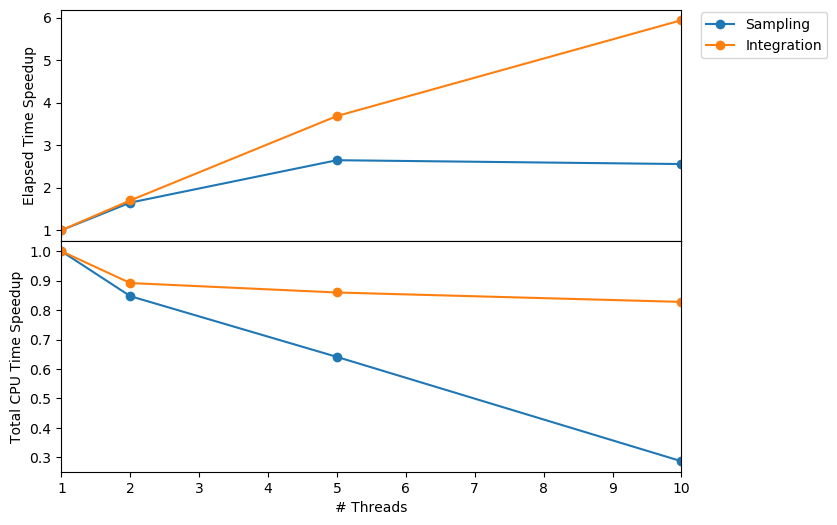

(1, 10)

In [12]:
sampling_wc_time = run_data.wc_sampling_time[1]
integration_wc_time = run_data.wc_integration_time[1]

sampling_cpu_time = run_data.cpu_sampling_time[1]
integration_cpu_time = run_data.cpu_integration_time[1]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_data.n_threads,  sampling_wc_time ./ run_data.wc_sampling_time, "o-", label = "Sampling")
ax[1].plot(run_data.n_threads,  integration_wc_time ./ run_data.wc_integration_time, "o-", label = "Integration")

ax[2].plot(run_data.n_threads,  sampling_cpu_time ./ run_data.cpu_sampling_time, "o-", label = "Sampling")
ax[2].plot(run_data.n_threads,  integration_cpu_time ./ run_data.cpu_integration_time, "o-", label = "Integration")

ax[1].legend(ncol=1, bbox_to_anchor=(1.02, 1.02))
ax[1].set_ylabel("Elapsed Time Speedup")
ax[2].set_ylabel("Total CPU Time Speedup")
ax[2].set_xlabel("# Threads")
ax[1].set_xlim(1,10)